<a href="https://colab.research.google.com/github/mferri17/amazon-reviews-sentiment-network-analysis/blob/master/network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Reviews Network Analysis - Ferri Marco, Basso Matteo

This project aims to experiment with network analysis on [Amazon Reviews](http://jmcauley.ucsd.edu/data/amazon/) in order to build a collaborative filtering model.

## Dataset

### Dependencies

In [0]:
import os
import gzip
import fileinput
import sys
import datetime
import io
import urllib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from fastai.collab import *
from sklearn.utils import resample

### Reading


Util functions to read from JSON and convert into pandas dataframe:

In [0]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  df = []
  for d in parse(path):
    df.append(d)
  return pd.DataFrame(df)

def read_dataset(dataset):      
  basepath = r"datasets\amazon-5-core"
  df = getDF(os.path.join(basepath, dataset))
  return df
  
def download_dataset(dataset):
  request = urllib.request.Request('http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/' + dataset)
  request.add_header('Accept-encoding', 'gzip')
  response = urllib.request.urlopen(request)
  buf = io.BytesIO(response.read())
  file = gzip.GzipFile(fileobj=buf)
  df = []
  for line in file:
    df.append(eval(line))
  return pd.DataFrame(df)

Reading from JSON

In [3]:
#%time dfull = read_dataset("reviews_Video_Games_5.json.gz")
%time dfull = download_dataset('reviews_Clothing_Shoes_and_Jewelry_5.json.gz')

CPU times: user 12.6 s, sys: 394 ms, total: 13 s
Wall time: 15.5 s


---

###  Description

#### Schema

In [4]:
print("(rows, cols) = ", dfull.shape)

(rows, cols) =  (278677, 9)


In [0]:
dfull = dfull.rename(index=str, columns={"asin": "productID", 
                                         "reviewerID": "userID", 
                                         "reviewerName": "userName",
                                         "reviewText": "text",
                                         "overall": "rating"})

In [6]:
dfull.info()

<class 'pandas.core.frame.DataFrame'>
Index: 278677 entries, 0 to 278676
Data columns (total 9 columns):
productID         278677 non-null object
helpful           278677 non-null object
rating            278677 non-null float64
text              278677 non-null object
reviewTime        278677 non-null object
userID            278677 non-null object
userName          278225 non-null object
summary           278677 non-null object
unixReviewTime    278677 non-null int64
dtypes: float64(1), int64(1), object(7)
memory usage: 21.3+ MB


In [7]:
dfull.head(3)

,productID,helpful,rating,text,reviewTime,userID,userName,summary,unixReviewTime
0,0000031887,"[0, 0]",5.0,This is a great tutu and at a really great pri...,"02 12, 2011",A1KLRMWW2FWPL4,"Amazon Customer ""cameramom""",Great tutu- not cheaply made,1297468800
1,0000031887,"[0, 0]",5.0,I bought this for my 4 yr old daughter for dan...,"01 19, 2013",A2G5TCU2WDFZ65,Amazon Customer,Very Cute!!,1358553600
2,0000031887,"[0, 0]",5.0,What can I say... my daughters have it in oran...,"01 4, 2013",A1RLQXYNCMWRWN,Carola,I have buy more than one,1357257600


#### Columns analysis

##### Users and products

In [8]:
(rows,cols) = dfull.shape
n_users = dfull['userID'].nunique()
n_products = dfull['productID'].nunique()
print("Number of REVIEWS: ", rows)
print("Number of USERS: ", n_users)
print("Number of PRODUCTS: ", n_products)
print("Average REVIEWS PER USER: ", rows/n_users)
print("Average REVIEWS PER PRODUCT: ", rows/n_products)

Number of REVIEWS:  278677
Number of USERS:  39387
Number of PRODUCTS:  23033
Average REVIEWS PER USER:  7.075354812501587
Average REVIEWS PER PRODUCT:  12.099031823904832


##### Datetime

In [9]:
dfull['date'] = pd.to_datetime(dfull['unixReviewTime'],unit='s')
print("First date: ", min(dfull['date']))
print("Last date: ", max(dfull['date']))

First date:  2003-03-29 00:00:00
Last date:  2014-07-23 00:00:00


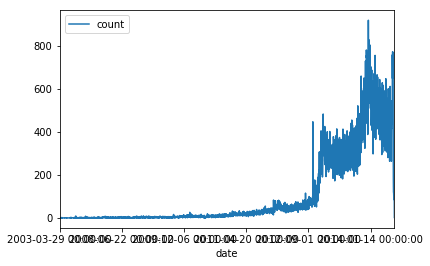

In [10]:
date_grouping = dfull.groupby('date').count()[['rating']].sort_values('date', ascending=True)
date_grouping = date_grouping.rename(index=str, columns={"rating": "count"})
date_grouping.plot()

##### Rating

In [11]:
print("Average rating: ", dfull['rating'].mean())

Average rating:  4.245133254628118


Rating distribution


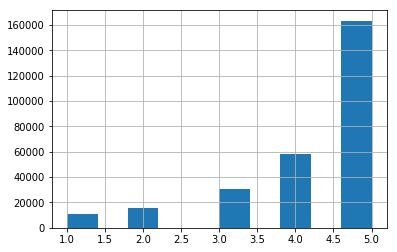

In [12]:
print("Rating distribution")
dfull['rating'].hist()

### Manipulation

#### Rejecting columns

In [0]:
dfull = dfull.drop(['helpful', 'reviewTime', 'unixReviewTime', 'userName', 'text', 'summary', 'sentiment'], axis = 1, errors = 'ignore')

In [14]:
dfull.info()

<class 'pandas.core.frame.DataFrame'>
Index: 278677 entries, 0 to 278676
Data columns (total 4 columns):
productID    278677 non-null object
rating       278677 non-null float64
userID       278677 non-null object
date         278677 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 10.6+ MB


#### Binarization

Since target variable (`rating`) is strongly unbalanced between low and high values, it is preferable to reduce the problem from multi-class to binary. Later on, some technique to manage unbalancement will be applied to the dataset, in order to fill the gap between the two binary classes.


In [0]:
# dfull['sentiment'] = ['positive' if r > 3 else 'negative' for r in dfull['rating']]

# print("Sentiment count")
# dfull['sentiment'].value_counts()

#### Undersampling

As previously seen, target column (`rating`) is strongly unbalanced towards the positive class. Undersampling of the majority class is necessary here to achieve good machine learning preformances later. This mainly afftects prediction models *recall* metric.

In [0]:

# # Separate majority and minority classes
# positive_count = dfull['sentiment'].value_counts()['positive']
# negative_count = dfull['sentiment'].value_counts()['negative']
# df_majority = dfull[dfull.sentiment==('positive' if positive_count >= negative_count else 'negative')]
# df_minority = dfull[dfull.sentiment==('negative' if positive_count >= negative_count else 'positive')]
 
# # Downsample majority class
# obj_samples = negative_count if positive_count >= negative_count else positive_count
# df_majority_downsampled = resample(df_majority, 
#                                  replace=False,
#                                  n_samples = obj_samples, # match minority class
#                                  random_state=123) # reproducible results
 
# # Combine minority class with downsampled majority class
# df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# # Display new class counts
# print("Positive/negative distribution post-undersampling")
# df_downsampled['sentiment'].value_counts()



---



***

## Network Graph

In [0]:
import scipy.sparse as sparse
import networkx as nx

**Reducing dataset**

In [18]:
print('Original reviews: ', len(dfull))

Original reviews:  278677


In [19]:
dfnet = dfull[(dfull['date'] > '2014-04-01')] # 1st of april
print('Reduced reviews: ', len(dfnet))

Reduced reviews:  49835


**Creating graph from Pandas data frame**

In [20]:
graph = nx.from_pandas_edgelist(df = dfnet, source = 'userID', target = 'productID', edge_attr = 'rating', create_using = nx.DiGraph)
graph

**Assertions**

In [21]:
net_users = dfnet.userID.nunique()
net_products = dfnet.productID.nunique()


edges = nx.number_of_edges(graph)
nodes = nx.number_of_nodes(graph)

assert edges == len(dfnet), 'wrong edge numbers (it must corresponds to record numbers = reviews)'
assert nodes == net_users + net_products, 'wrong nodes numbers (it must corresponds to number of users plus number of products)'
print("Edges (reviews): ", edges)
print("Nodes (users + products): ", nodes)

print()

givers_nodes = [node_degree for node_degree in graph.out_degree() if node_degree[1] > 0]
receivers_nodes = [node_degree for node_degree in graph.in_degree() if node_degree[1] > 0]

assert len(givers_nodes) == net_users, 'source nodes differ from users'
assert len(receivers_nodes) == net_products, 'target nodes differ from products'
print("Users nodes: ", len(givers_nodes))
print("Products nodes: ", len(receivers_nodes))

Edges (reviews):  49835
Nodes (users + products):  33267

Users nodes:  18009
Products nodes:  15258


**Example**

In [22]:
userID = dfnet.head(1)['userID'][0]
productID = dfnet.head(1)['productID'][0]

print('Products reviewed by user', userID, ':\n', list(graph.successors(userID)))
print()
print('Users who reviewed product', productID, ':\n', list(graph.predecessors(productID)))

Products reviewed by user A8U3FAMSJVHS5 :
 ['0000031887', 'B0002USAW8', 'B001AZJVPO', 'B002NPCJ5E', 'B003DZ11ZC', 'B004QLBTD6', 'B0071645IO', 'B007A2OGV0']

Users who reviewed product 0000031887 :
 ['A8U3FAMSJVHS5', 'A16GFPNVF4Y816', 'A2XJ13PIXVJFJH']


**Saving to graphML file**

In [23]:
from google.colab import drive
drive.mount('/content/drive')
drivepath = '/content/drive/My Drive/Data Analytics/'

nx.write_graphml(graph, drivepath + 'test.graphml')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Degrees**

In [24]:
degrees = [node_degree[1] for node_degree in graph.degree()]
print("Average degree:\t", np.mean(degrees))

in_degrees = [node_degree[1] for node_degree in givers_nodes]
print("Average in degree:\t", np.mean(in_degrees))

out_degrees = [node_degree[1] for node_degree in receivers_nodes]
print("Average out degree:\t", np.mean(out_degrees))

Average degree:	 2.9960621637057745
Average in degree:	 2.76722749736243
Average out degree:	 3.266155459431118


### Fail

**Dataframe manipulation to create adjacency matrix**

Both products and users have to be drawn in the network graph, so they must have 

In [0]:
# dfnet = dfull.copy()

# #n_users = dfnet['userID'].nunique()
# n_products = dfnet['productID'].nunique()

# # converting strings to categories
# series2cat(dfnet, 'productID', 'userID')

# # converting categories to integer
# dfnet['productID'] = dfnet.productID.cat.codes
# dfnet['userID'] = dfnet.userID.cat.codes + n_products # products and users id must be different
# dfnet['rating'] = pd.to_numeric(dfnet['rating'], downcast='integer')

# # reordering columns
# dfnet = dfnet[['userID', 'productID', 'rating']]
# dfnet.info()

**Converting pandas dataframe to sparse Scipy's adjacency matrix**

Rows are **users**, columns are **products**. Values are **ratings**.

In [0]:
# https://stackoverflow.com/questions/29146892/numpy-scipy-build-adjacency-matrix-from-weighted-edgelist

# arr = np.array(dfnet)
# n_nodes = max(tuple(arr.max(axis=0)+1)) # getting adj matrix square shape
# coo = sparse.coo_matrix((arr[:, 2], (arr[:, 0], arr[:, 1])), shape=(n_nodes,n_nodes), dtype=arr.dtype)

**Creating graph from adjacency matrix**

In [0]:
# graph = nx.from_scipy_sparse_matrix(coo, create_using=nx.DiGraph)

# assert nx.number_of_edges(graph) == len(dfnet), 'wrong edge numbers (it must corresponds to record numbers = reviews)'
# assert nx.number_of_nodes(graph) == n_users + n_products, 'wrong nodes numbers (it must corresponds to number of users plus number of products)'



---



## Centrality Measures

### Degree Centrality ??

In [28]:
nodes_degree_centralities = nx.algorithms.centrality.degree_centrality(graph)
print('Average degree centrality:', np.mean([x for x in nodes_degree_centralities.values()]))

in_nodes_degree_centralities = nx.algorithms.centrality.in_degree_centrality(graph)
print('Average in degree centrality:', np.mean([x for x in in_nodes_degree_centralities.values()]))

out_nodes_degree_centralities = nx.algorithms.centrality.out_degree_centrality(graph)
print('Average out degree centrality:', np.mean([x for x in out_nodes_degree_centralities.values()]))

Average degree centrality: 9.006379377459791e-05
Average in degree centrality: 4.5031896887298956e-05
Average out degree centrality: 4.503189688729896e-05




---



## Popularity Filtering



---



## Collaborative Filtering

### Undersampling

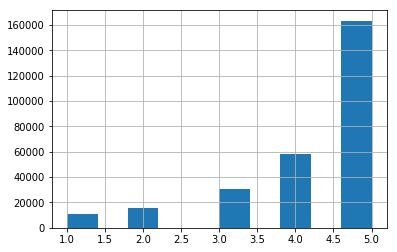

In [29]:
dfull['rating'].hist()

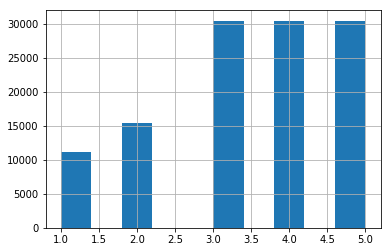

In [30]:
# # Separate majority and minority classes
df_minority = dfull[(dfull.rating!=5) & (dfull.rating!=4)]
df_4 = dfull[dfull.rating==4]
df_5 = dfull[dfull.rating==5]
resampling_count = dfull['rating'].value_counts()[3]
 
# Downsample majority class
df_4_down = resample(df_4, 
                     replace=False,
                     n_samples = resampling_count,
                     random_state=123) # reproducible results

# Downsample majority class
df_5_down = resample(df_5, 
                     replace=False,
                     n_samples = resampling_count,
                     random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_minority, df_4_down, df_5_down])
 
# Display new class counts
df_downsampled['rating'].hist()

### Creating dataset for collaborative filtering

In [31]:
dflearn = df_downsampled
dflearn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117930 entries, 15 to 262698
Data columns (total 4 columns):
productID    117930 non-null object
rating       117930 non-null float64
userID       117930 non-null object
date         117930 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 4.5+ MB


In [32]:
# converting strings to categories
series2cat(dflearn, 'productID', 'userID')

# reordering columns for fastai standard format
dflearn = dflearn[['userID', 'productID', 'rating']]
dflearn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117930 entries, 15 to 262698
Data columns (total 3 columns):
userID       117930 non-null category
productID    117930 non-null category
rating       117930 non-null float64
dtypes: category(2), float64(1)
memory usage: 4.8+ MB


In [33]:
# creating collaborative filtering dataset
data = CollabDataBunch.from_df(dflearn, seed=42, valid_pct = 0.2)
data.show_batch()

userID,productID,target
AGH7CAV7REAL0,B00E1JPW0E,4.0
A168UNVODFOWU3,B000G5TDGQ,4.0
A2VW5QYY56BT1S,B005VNFCZO,3.0
A1N5PHW99PM5DL,B000ZHZRTM,3.0
A6K47JSRTUS90,B009D3IXGI,4.0


In [0]:
n_cicles = 5

### EmbeddingDotBias

Training results


epoch,train_loss,valid_loss,time
0,1.743303,1.733613,00:11
1,1.642146,1.671777,00:12
2,1.291814,1.652049,00:12
3,0.970356,1.648955,00:12
4,0.742901,1.649019,00:12


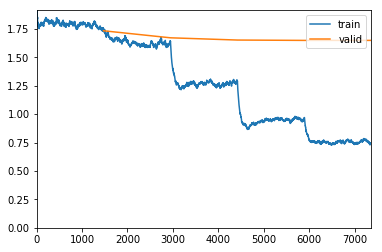

In [35]:
learn = collab_learner(data, n_factors=50, y_range=(1,5), use_nn = False, callback_fns=ShowGraph)
#learn.loss_func = torch.nn.MSELoss() # changing loss function (default is MSE)

print('Training results')
learn.fit_one_cycle(n_cicles, 5e-3, wd=0.1)

# learn.save('amazon-reviews-dot-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


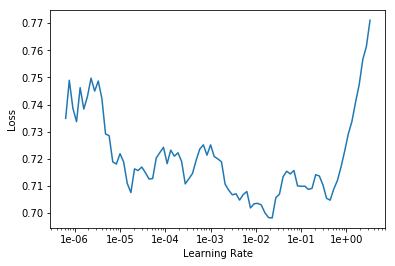

In [36]:
learn.unfreeze()
learn.lr_find() # find learning rate
learn.recorder.plot() # plot learning rate graph

#### Interpretation

Trovato qui, ma non so cosa significhi https://towardsdatascience.com/collaborative-filtering-with-fastai-3dbdd4ef4f00

In [37]:
g = dflearn.groupby('productID')['rating'].count()
top_ratings = g.sort_values(ascending=False).index.values[:1000]
top_ratings = top_ratings.astype(str)
top_ratings

array(['B005LERHD8', 'B005GYGD7O', 'B000T9VK56', 'B002RADHJC', ..., 'B005LMTW6K', 'B007BZ5CUU', 'B000SMNL2E',
       'B003YJ4RYO'], dtype='<U10')

In [38]:
# get biases for top products
product_bias = learn.bias(top_ratings, is_item=True)

# get mean ratings
mean_ratings = dflearn.groupby('productID')['rating'].mean()
product_ratings = [(b, top_ratings[i], mean_ratings.loc[tb]) for i, (tb, b) in enumerate(zip(top_ratings, product_bias))]

# print product bias information
item0 = lambda o:o[0]
print(sorted(product_ratings, key=item0)[:15])
print(sorted(product_ratings, key=item0, reverse=True)[:15])

# get weights
product_w = learn.weight(top_ratings, is_item=True)

# transform weights to 3 dimensions
product_pca = product_w.pca(3)

# get prinicipal components
fac0,fac1,fac2 = product_pca.t()
product_comp = [(f, i) for f,i in zip(fac0, top_ratings)]

# print fac0 information
print(sorted(product_comp, key=itemgetter(0), reverse=True)[:10])
print(sorted(product_comp, key=itemgetter(0))[:10])

# print fac1 information
product_comp = [(f, i) for f,i in zip(fac1, top_ratings)]
print(sorted(product_comp, key=itemgetter(0), reverse=True)[:10])
print(sorted(product_comp, key=itemgetter(0))[:10])

[(tensor(-0.5433), 'B00DNV1IJK', 1.75), (tensor(-0.4035), 'B00DM0587K', 2.1176470588235294), (tensor(-0.3652), 'B00AFPZBUY', 2.0625), (tensor(-0.3643), 'B00FEEA4MG', 2.12), (tensor(-0.3633), 'B004WKRAB6', 1.8333333333333333), (tensor(-0.3589), 'B008KM948O', 2.25), (tensor(-0.3449), 'B00DMWQLB0', 2.4358974358974357), (tensor(-0.3288), 'B002K6F79G', 2.706896551724138), (tensor(-0.3194), 'B00IE5QR64', 2.2083333333333335), (tensor(-0.3169), 'B00FF394VI', 2.238095238095238), (tensor(-0.3040), 'B003WJRVHG', 2.5), (tensor(-0.2937), 'B004ZGBXUQ', 2.235294117647059), (tensor(-0.2925), 'B00A76LPU6', 2.0), (tensor(-0.2670), 'B00E8CN6MA', 2.3684210526315788), (tensor(-0.2670), 'B002JWF6OC', 2.45)]
[(tensor(0.7476), 'B002PHLVJA', 4.339285714285714), (tensor(0.6826), 'B0058XIMMM', 3.961038961038961), (tensor(0.6600), 'B0013KDS96', 4.483870967741935), (tensor(0.5914), 'B0068VM5T4', 4.191489361702128), (tensor(0.5781), 'B00BNB36ZG', 4.225806451612903), (tensor(0.5604), 'B000WUOVXK', 4.4), (tensor(0.55

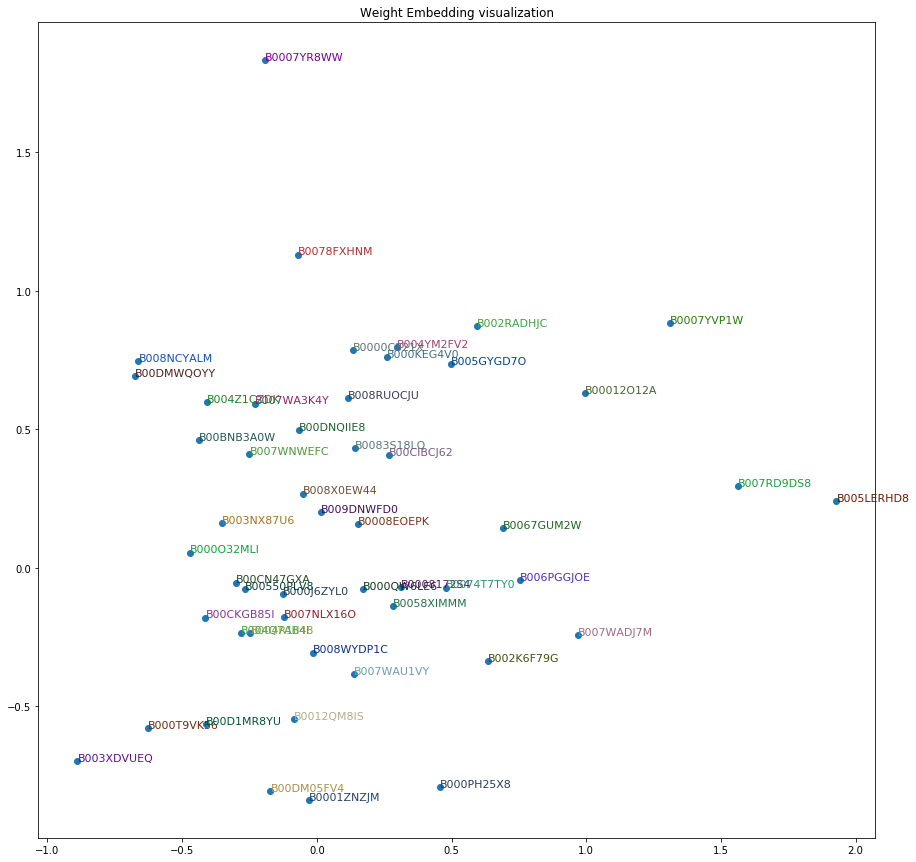

In [39]:
idxs = np.random.choice(len(top_ratings), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_ratings[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.title('Weight Embedding visualization')
plt.show()

### EmeddingNN

In [40]:
learn = collab_learner(data, use_nn=True, emb_szs={'userID': 40, 'productID':40}, layers=[256, 128], y_range=(1, 5))
learn.fit_one_cycle(n_cicles, 5e-3, wd=0.1)

# learn.save('amazon-reviews-nn-1')

epoch,train_loss,valid_loss,time
0,1.527893,1.544509,00:14
1,1.485407,1.517108,00:14
2,1.293632,1.565487,00:14
3,0.952338,1.696732,00:14
4,0.531923,1.865674,00:14


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
# interp.confusion_matrix()